# Explore here

In [2]:
# Importamos modulos necesarios

# manejo de datos
import pandas as pd
import numpy as np
# graficos
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
# Escalar
from sklearn.preprocessing import MinMaxScaler
# optimizar
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
from skopt import BayesSearchCV
# Metricas de error
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
 
# Para eliminar un mensaje de alerta de pandas relacionado con la copia de un dataframe
pd.options.mode.copy_on_write = True

In [3]:
def corr_highlighted_target(dataframe, target):
    corr = dataframe.corr()
    # Generar el mapa de calor de la matriz de correlación
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Coeficiente de correlación'})

    # Resaltar la columna y fila de la variable objetivo
    # Encontrar el índice de la variable objetivo en las columnas
    target_index = dataframe.columns.tolist().index(target)

    # Cambiar el color de la columna y fila correspondiente a la variable objetivo
    plt.gca().add_patch(plt.Rectangle((target_index, 0), 1, len(corr), fill=False, edgecolor='blue', lw=3))
    plt.gca().add_patch(plt.Rectangle((0, target_index), len(corr), 1, fill=False, edgecolor='blue', lw=3))

    plt.show()

In [4]:
# Importamos el dataset
df = pd.read_csv('AB_NYC_2019.csv')
# Mostramos todas las columnas
pd.set_option('display.max_columns', None)
# Visualizacion de la estructura general // primer analisis
display(df.head(2))
display(df.tail(2))

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.65,-73.97,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75,-73.98,Entire home/apt,225,1,45,2019-05-21,0.38,2,355


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
48893,36485609,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.76,-73.99,Shared room,55,1,0,NaN,NaN,6,2
48894,36487245,Trendy duplex in the very heart of Hell's Kitchen,68119814,Christophe,Manhattan,Hell's Kitchen,40.76,-73.99,Private room,90,7,0,NaN,NaN,1,23


### LIMPIEZA DE DATOS

In [5]:
# Cargo funcion personal de practica // informacion agrupada de los dataframes
def df_info(df):
    df_info = pd.DataFrame({
        'nunique': df.nunique(),
        'nulls': df.isnull().sum(),
        'percent_nulls' : df.isnull().mean()*100,
        'Dtype': df.dtypes,
        'non_null': df.count(),
        'total_values': len(df)  
    })
    types_counter = df_info['Dtype'].value_counts()
    duplicated = df.duplicated().sum()
    display(df_info, types_counter)
    print(f'El dataframe tiene {df.shape[0]} filas y {df.shape[1]} columnas')
    print(f'Hay {duplicated} valores duplicados')

# Llamo a la funcion y buscamos nulos y duplicados
df_info(df)

,nunique,nulls,percent_nulls,Dtype,non_null,total_values
id,48895,0,0.00,int64,48895,48895
name,47905,16,0.03,object,48879,48895
host_id,37457,0,0.00,int64,48895,48895
host_name,11452,21,0.04,object,48874,48895
neighbourhood_group,5,0,0.00,object,48895,48895
neighbourhood,221,0,0.00,object,48895,48895
latitude,19048,0,0.00,float64,48895,48895
longitude,14718,0,0.00,float64,48895,48895
room_type,3,0,0.00,object,48895,48895
price,674,0,0.00,int64,48895,48895


Dtype
int64      7
object     6
float64    3
Name: count, dtype: int64

El dataframe tiene 48895 filas y 16 columnas
Hay 0 valores duplicados


- Tenemos 6 columnas categoricas que habra que analizar. En caso de que  tengan valor predictivo buscaremos el mejor metodo para codificarlas.

- Las columnas last_review, reviews_per_month, name y host name tienen valores nulos.

- No hay ninguna columna binaria

In [6]:
cat_cols = ['last_review', 'room_type', 'host_name', 'neighbourhood','neighbourhood_group','name' ]

In [7]:
# Eliminamos dos variables categoricas que carecen de valor predictivo para este caso y tienen valores nulos // 
df.drop(['name','host_name'],  axis=1, inplace=True)

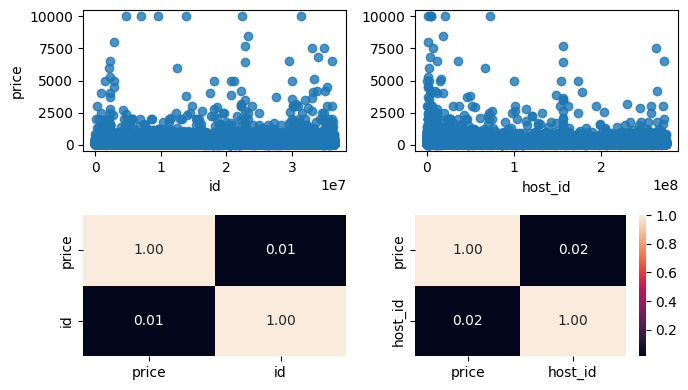

In [8]:
# Crear un diagrama de dispersión múltiple para visualizar dos columnas que dudo si eliminar o no // id y host_id
fig, axis = plt.subplots(2, 2, figsize = (7, 4))


# Crear un diagrama de dispersión múltiple para visualizar dos columnas que dudo si eliminar o no
sns.regplot(ax = axis[0, 0], data = df, x = 'id', y = "price")
sns.heatmap(df[["price", "id"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 0], cbar = False)
sns.regplot(ax = axis[0, 1], data = df, x = "host_id", y = "price").set(ylabel=None)
sns.heatmap(df[["price", "host_id"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 1])


# Ajustar el layout
plt.tight_layout()

# Mostrar el plot
plt.show()

Las columnas 'id' y 'host_id' son valores de identificacion y  en su mayoria valores unicos. No añaden informacion a las caracteristicas de las habitaciones.

Tampoco tienen apenas correlacion con la variable objetivo y sí varios valores nulos por lo que se eliminan 

Ademas:

Las columnas 'last_review', 'reviews_per_month' contienen un 20% de valores faltantes. Descarto imputarlos ya que:

- En primer lugar intuyo que no tienen un alto valor predictivo

- En segundo lugar, contamos con la columna 'number_of_reviews' que contiene el mismo tipo de información

- Teniendo en cuenta los dos puntos anteriores no veo acertado añadir ruido al modelo y se eliminan.




In [9]:
# Eliminamos columnas irrelevantes
df.drop(['last_review', 'reviews_per_month', 'id', 'host_id'],  axis=1, inplace=True)
# Comprobamos que ya no hay valores faltantes
df.isna().sum()

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [10]:
# Eliminamos precios iguales o menores a 0
df = df[df['price'] > 0]

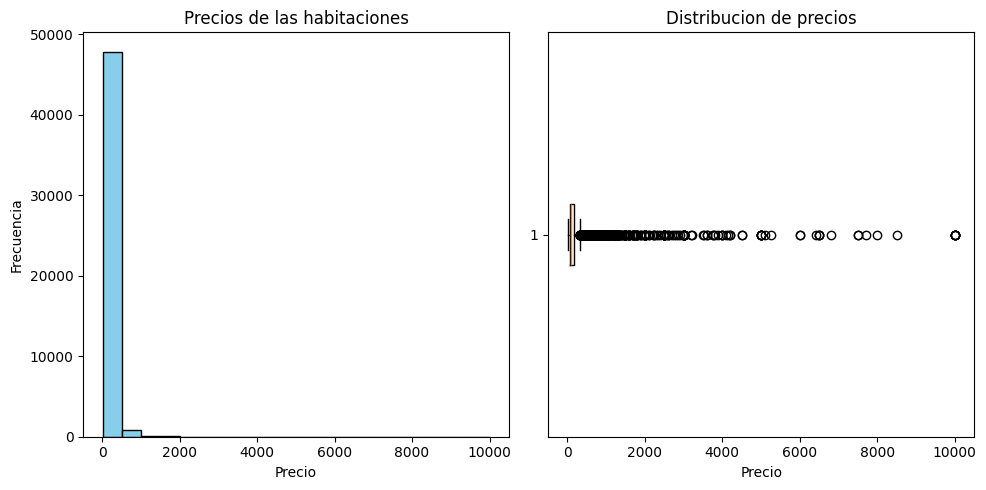

In [11]:
#Visualizacion de la distribucion de la variable objetivo

# Crear un grid para dos plots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Histograma de precios
ax[0].hist(df['price'], bins=20, color='skyblue', edgecolor='black')
ax[0].set_title('Precios de las habitaciones')
ax[0].set_xlabel('Precio')
ax[0].set_ylabel('Frecuencia')

# Boxplot de precios
ax[1].boxplot(df['price'], vert=False)
ax[1].set_title('Distribucion de precios')
ax[1].set_xlabel('Precio')

# Mostrar la figura
plt.tight_layout()
plt.show()

Nos encontramos con una distribucion de precios extremadamente sesgada a la derecha que intentaremos normalizar en la siguiente linea de codigo

In [12]:
# Creamos una nueva columna aplicando un logaritmo natural a la columna 'price' que nos proporcionara una distribución de valores mas normalizada
df['LOG_PRICE'] = np.log(df.price)

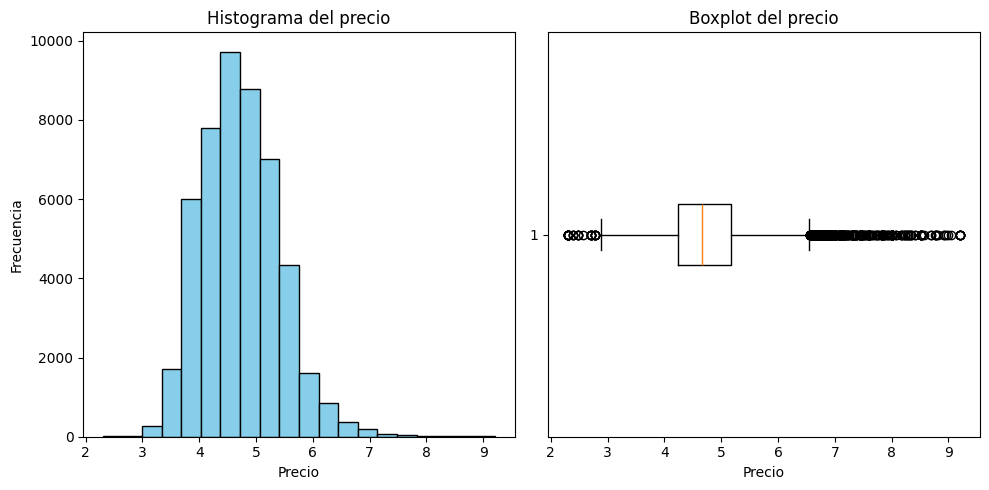

In [13]:
# Grafico de distribucion de la nueva columna LOG_PRICE

# Grid para dos plots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Histograma de distribucion de frecuencia de precios
ax[0].hist(df['LOG_PRICE'], bins=20, color='skyblue', edgecolor='black')
ax[0].set_title('Histograma del precio')
ax[0].set_xlabel('Precio')
ax[0].set_ylabel('Frecuencia')

# Boxplot de distribucion de precios
ax[1].boxplot(df['LOG_PRICE'], vert=False)
ax[1].set_title('Boxplot del precio')
ax[1].set_xlabel('Precio')
# Mostrar la figura
plt.tight_layout()
plt.show()

- Tenemos una distribucion mas normalizada despues de aplicar el logaritmo a la columna precios, no obstante se aprecia que la grafica esta sesgada a derecha.
- En el boxplot tambien se aprecia el sesgo a derecha y multiples outliers

In [14]:
# Eliminamos la columna price para que no lleve a confusion. Solo hay que tener en cuenta aplicar la exponencial al resultado final para que de el valor en el formato original
df.drop('price', axis=1, inplace=True)
df.head(1)

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,LOG_PRICE
0,Brooklyn,Kensington,40.65,-73.97,Private room,1,9,6,365,5.00


### ANALISIS DE LAS VARIABLES NUMERICAS

In [15]:
# Procedemos con la busqueda de datos atipicos en las variables cuantitativas

# Variables independientes  y dependiente + eliminacion de variables categoricas
X = df.drop(['neighbourhood_group','neighbourhood','room_type', 'LOG_PRICE'], axis=1)
y = df['LOG_PRICE']

# modelo ordinary least squares para aplicarle el metodo  get_influence().cooks_distance
X = sm.add_constant(np.asarray(X))
model = sm.OLS(y, X).fit()

# Obtenemos la distancia de cook para las observaciones
cooks_distance = model.get_influence().cooks_distance


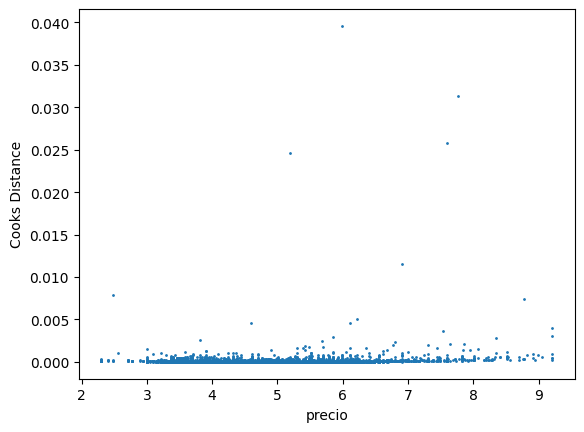

In [16]:
# Graficamos el resultado de cooks_distance
plt.scatter(df.LOG_PRICE, cooks_distance[0], s=1)
plt.xlabel('precio')
plt.ylabel('Cooks Distance')
plt.show()

In [17]:
# Buscamos la distancia de cook optima
optimal_cooks_distance = 4/len(cooks_distance[0])
optimal_cooks_data = np.where(cooks_distance[0]>= optimal_cooks_distance)
# Cantidad de terminos a eliminar
print(optimal_cooks_data[0].size)
# Siguiendo la regla de 4/n para la distancia de cook optima eliminamos 2160 filas  (4.41%) de los datos
df.drop(optimal_cooks_data[0], axis=0, inplace=True)



2160


In [18]:
# Filtramos los valores atipicos de LOG_PRICE
df = df[(df['LOG_PRICE']<6.5) & (df['LOG_PRICE']>2.9)]

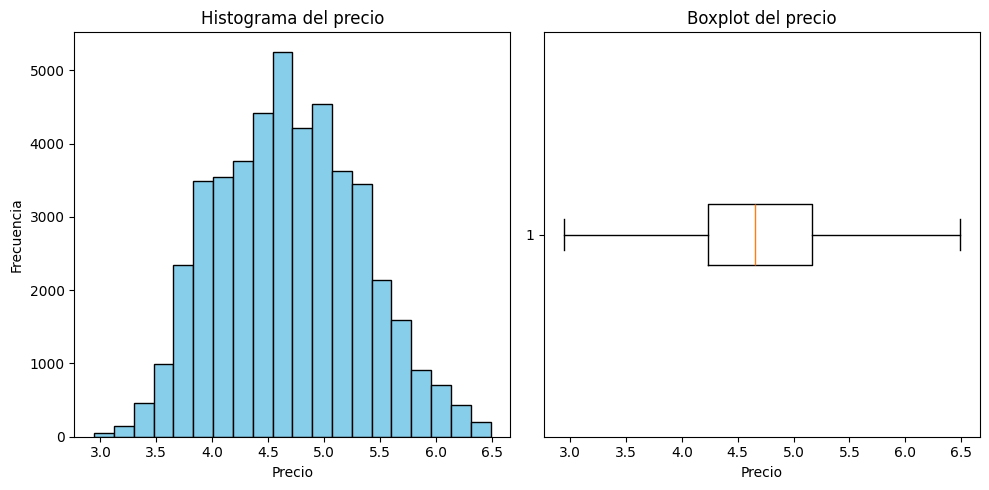

In [19]:
# Graficamos el resultado de los ajustes

# Grid para dos plots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Histograma de distribucion de frecuencia de precios despues de eliminar datos atipicos
ax[0].hist(df['LOG_PRICE'], bins=20, color='skyblue', edgecolor='black')
ax[0].set_title('Histograma del precio')
ax[0].set_xlabel('Precio')
ax[0].set_ylabel('Frecuencia')

# Boxplot de distribucion de precios
ax[1].boxplot(df['LOG_PRICE'], vert=False)
ax[1].set_title('Boxplot del precio')
ax[1].set_xlabel('Precio')
# Mostrar la figura
plt.tight_layout()
plt.show()

In [20]:
# Vuelvo a llamar a la funcion de info para ver como va quedando el df
df_info(df)

,nunique,nulls,percent_nulls,Dtype,non_null,total_values
neighbourhood_group,5,0,0.00,object,46243,46243
neighbourhood,217,0,0.00,object,46243,46243
latitude,18557,0,0.00,float64,46243,46243
longitude,14224,0,0.00,float64,46243,46243
room_type,3,0,0.00,object,46243,46243
minimum_nights,96,0,0.00,int64,46243,46243
number_of_reviews,363,0,0.00,int64,46243,46243
calculated_host_listings_count,47,0,0.00,int64,46243,46243
availability_365,366,0,0.00,int64,46243,46243
LOG_PRICE,489,0,0.00,float64,46243,46243


Dtype
int64      4
object     3
float64    3
Name: count, dtype: int64

El dataframe tiene 46243 filas y 10 columnas
Hay 0 valores duplicados


### CODIFICACION DE VARIABLES CATEGORICAS

- Ahora hay que decidir como codificar las coordenadas geograficas // he valorado usar el clustering y la distancia a POI 


In [21]:
# Distancia a POI (centro de new york)
# En primer lugar confirmo que los precios mas altos estan en torno al dentro geografico de la cuidad

# Encontramos los 100 precios mas altos 
df_reset = df.reset_index(drop=True) # Conveniente despues de haber estado filtrando y eliminando filas para poder acceder a los indices que obtendremos
# Hallamos los 100 valores mas altos con nlargest y sus indices dentro de dataframe con .index
top100_indices = df_reset['LOG_PRICE'].nlargest(100).index 
# Dataframe con esos valores
df_top100 = df_reset.iloc[top100_indices]


# importamos la libreria que nos permitira ver esos valores en el plano
import folium

# Creamos el plano y definimos su posicion inicial
mapa_top_100 = folium.Map(location=[40.71427 , -74.00597]) # Centro de NY segun GMaps

# Añadimos los 100 valores maximos de precio al plano con sus coordenadas
df_top100.apply(lambda row:folium.CircleMarker(location=[row["latitude"], row["longitude"]] ).add_to(mapa_top_100), axis=1)

# Creamos un punto con las coordenadas del centro de la ciudad
folium.CircleMarker(
    location=[40.71427 , -74.00597],
    radius=10,
    color="black",
    stroke=True,
    fill=True,
    fill_opacity=1,
    fill_color='red',
    opacity=1,
    popup="{} pixels".format(10),
    tooltip="I am in pixels",
).add_to(mapa_top_100)

# Mostramos el mapa
mapa_top_100

Confirmado que los mayores precios estan en su mayoria proximos al centro procedemos con la codificacion por distancia a punto

In [22]:
# Codificacion de las variables latitude y longitude // Aplicamos la codificacion basada en distancia a POI

# Coordenadas del centro de NY (latitud y longitud)
lat_centro, lon_centro = 40.71427 , -74.00597   # Centro de Nueva York

# Creamos la columna que referencia la distancia de cada habitacion al centro // No es mas que la formula de la distancia euclidiana // 
# Se usa este metodo porque en distancias tan cortas la curvatura de la tierra es despreciable
df['distance_to_center'] = np.sqrt((df['latitude'] - lat_centro)**2 + (df['longitude'] - lon_centro)**2)

La segunda posibilidad para codificar las coordenadas geograficas es el clustering

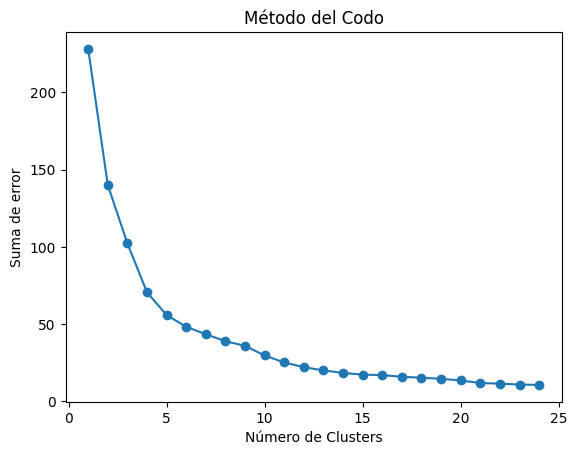

In [23]:
#Ahora a por el segundo metodo // clustering

# Se aplica el metodo del codo para hallar el numero optimo de clusteres
Suma_error_cuadratico = []
for k in range(1, 25):  # probaremos de 1 a 24 clusters siendo k el numero de clusters
    kmeans = KMeans(n_clusters=k, random_state=42) # Se crea una instancia de kmeans para cada valor de k
    kmeans.fit(df[['latitude', 'longitude']])      # Se aplica kmeans a las coordenadas geograficas
    Suma_error_cuadratico.append(kmeans.inertia_)  # añadimos las distancias**2 hasta el centroide mas cercano a la suma total a la lista vacia inicializada antes (Suma_error_cuadratico)

# Ploteamos la lista obtenida dentro de los clusters en función del número de clusters
plt.plot(range(1, 25), Suma_error_cuadratico, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters')
plt.ylabel('Suma de error')
plt.show()

# Me quedo con 14 clusters para la codificacion de las coordenadas

In [24]:
kmeans = KMeans(n_clusters=14, random_state=0, n_init="auto").fit(df[['latitude', 'longitude']])
df['clusters'] = kmeans.labels_

In [25]:
df.head(10)

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,LOG_PRICE,distance_to_center,clusters
0,Brooklyn,Kensington,40.65,-73.97,Private room,1,9,6,365,5.00,0.07,1
1,Manhattan,Midtown,40.75,-73.98,Entire home/apt,1,45,2,355,5.42,0.05,9
2,Manhattan,Harlem,40.81,-73.94,Private room,3,0,1,365,5.01,0.11,3
3,Brooklyn,Clinton Hill,40.69,-73.96,Entire home/apt,1,270,1,194,4.49,0.05,12
4,Manhattan,East Harlem,40.80,-73.94,Entire home/apt,10,9,1,0,4.38,0.10,3
5,Manhattan,Murray Hill,40.75,-73.97,Entire home/apt,3,74,1,129,5.30,0.05,9
6,Brooklyn,Bedford-Stuyvesant,40.69,-73.96,Private room,45,49,1,0,4.09,0.06,12
8,Manhattan,Upper West Side,40.80,-73.97,Private room,2,118,1,0,4.37,0.10,3
9,Manhattan,Chinatown,40.71,-73.99,Entire home/apt,1,160,4,188,5.01,0.02,4
10,Manhattan,Upper West Side,40.80,-73.97,Entire home/apt,5,53,1,6,4.91,0.10,3


- En primer lugar, para determinar que metodo de codificacion ha sido mas efectivo al capturar la informacion original, creamos un mapa de correlacion.
- Ademas echaremos un vistazo al resto de correlaciones para empezar a filtrar columnas innecesarias

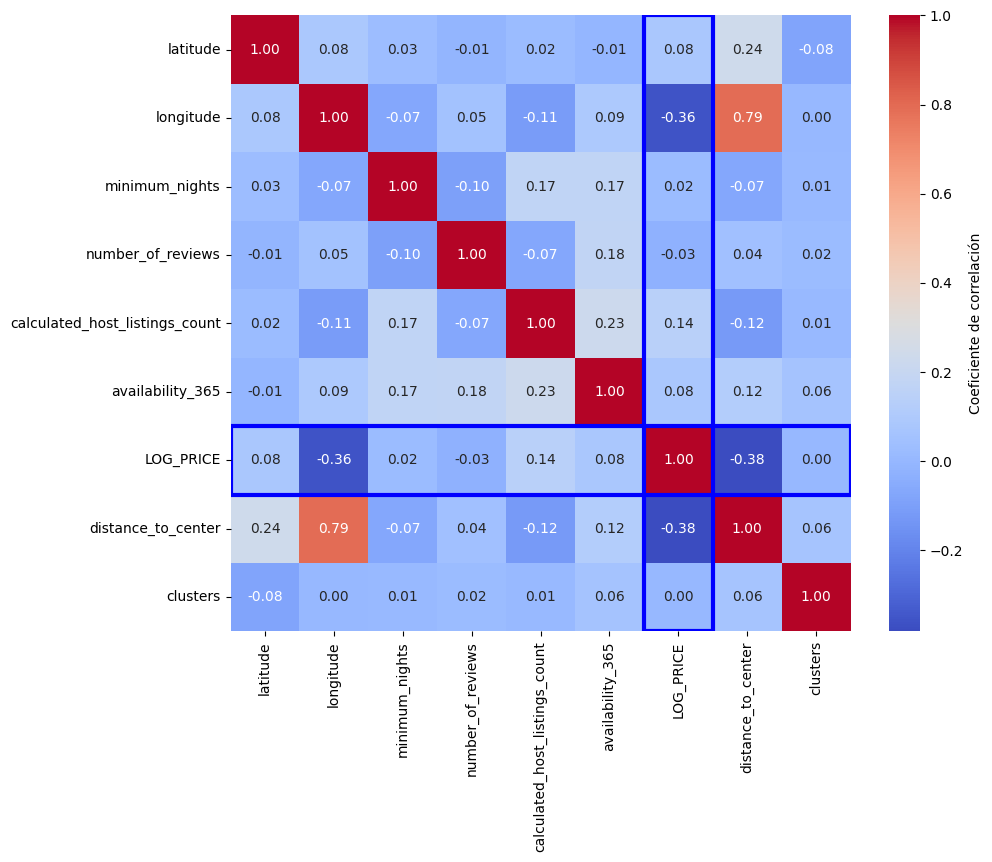

In [26]:
# Filtramos por variables numericas
df_for_corr = df.drop(['neighbourhood_group', 'neighbourhood', 'room_type' ], axis=1)
# Observamos el mapa de correlaciones

corr_highlighted_target(df_for_corr, 'LOG_PRICE')


- El clustering de coordenadas tiene menor correlacion con el precio que la distancia al centro //  se elimina y nos quedamos con la distancia al centro

- Se eliminan las columnas originales de coordenadas geograficas

- Minimum_nights, number_of_reviews, availability_365 tampoco tienen  apenas correlacion con el precio // se eliminan


In [27]:
# en una primera prueba elimine 'minimum_nights', 'number_of_reviews', 'availability_365' por su baja correlacion pero las mtericas del modelo final empeoraban bastante 
''' columnas_a_eliminar = ['longitude', 'latitude', 'coords_cluster', 'minimum_nights', 'number_of_reviews', 'availability_365' ] '''

columnas_a_eliminar = ['longitude', 'latitude']
df = df.drop(columnas_a_eliminar, axis=1)

####                                Las variables numericas preparadas. vamos a por las categoricas

In [28]:
# Compruebo como queda el dataframe
df_info(df)

,nunique,nulls,percent_nulls,Dtype,non_null,total_values
neighbourhood_group,5,0,0.00,object,46243,46243
neighbourhood,217,0,0.00,object,46243,46243
room_type,3,0,0.00,object,46243,46243
minimum_nights,96,0,0.00,int64,46243,46243
number_of_reviews,363,0,0.00,int64,46243,46243
calculated_host_listings_count,47,0,0.00,int64,46243,46243
availability_365,366,0,0.00,int64,46243,46243
LOG_PRICE,489,0,0.00,float64,46243,46243
distance_to_center,46214,0,0.00,float64,46243,46243
clusters,14,0,0.00,int32,46243,46243


Dtype
int64      4
object     3
float64    2
int32      1
Name: count, dtype: int64

El dataframe tiene 46243 filas y 10 columnas
Hay 0 valores duplicados


In [29]:
# Target Encoding para codificar la columna neighbourhood // al contar con 218 valores unicos, descarto one_hot. El label encoding por su parte, aportaria una 'ordinalidad' artificial a los valores originales.


# Me ha costado la vida, pero he creado esta funcion para hacer target encoding en el futuro facilmente
def target_encoding(dataframe, column, target_column, smooth_coef=0):
    column, target_column = str(column), str(target_column)
    conteo_columna = dataframe.groupby(column)[target_column].count().reset_index(name= 'conteo')
    # Calculamos el promedio de LOGPRICE por vecindario
    promedio_columna = dataframe.groupby(column)[target_column].mean().reset_index(name= 'column_mean')
    # Unimos conteo y promedio en el mismo DF en base al vecindario
    final_df = promedio_columna.merge(conteo_columna, on=column)
    # Hallamos el promedio global 
    global_mean = dataframe[target_column].mean()
    # Asignamos coeficiente de suavizado
    m = smooth_coef
    # Calculamos precio suavizado para cada vecindario
    final_df[f'encoded_{column}'] = (final_df['conteo'] * final_df['column_mean'] + m * global_mean) / final_df['conteo'] + m
    # Creamos un diccionario para poder relacionar cada promedio con su valor original mas adelante
    encoded_value_dict = pd.Series(final_df[f'encoded_{column}'].values, index= final_df[column]).to_dict()
    # Fusionamos el dataframe original con el dataframe vecindarios en base a la columna 'neighbourhood'
    result_df = dataframe.merge(final_df[[column,str(f'encoded_{column}')]], on=column, how='left')
    return result_df

df = target_encoding(df, 'neighbourhood', 'LOG_PRICE' )
df


,neighbourhood_group,neighbourhood,room_type,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,LOG_PRICE,distance_to_center,clusters,encoded_neighbourhood
0,Brooklyn,Kensington,Private room,1,9,6,365,5.00,0.07,1,4.34
1,Manhattan,Midtown,Entire home/apt,1,45,2,355,5.42,0.05,9,5.29
2,Manhattan,Harlem,Private room,3,0,1,365,5.01,0.11,3,4.54
3,Brooklyn,Clinton Hill,Entire home/apt,1,270,1,194,4.49,0.05,12,4.76
4,Manhattan,East Harlem,Entire home/apt,10,9,1,0,4.38,0.10,3,4.63
...,...,...,...,...,...,...,...,...,...,...,...
46238,Brooklyn,Bedford-Stuyvesant,Private room,2,0,2,9,4.25,0.07,12,4.43
46239,Brooklyn,Bushwick,Private room,4,0,2,36,3.69,0.07,7,4.26
46240,Manhattan,Harlem,Entire home/apt,10,0,1,27,4.74,0.12,6,4.54
46241,Manhattan,Hell's Kitchen,Shared room,1,0,6,2,4.01,0.05,9,5.10


In [30]:
# La variable categorica neighbourhood_group solo tiene 4 valores asi que opto por one_hot
# Instanciamos el metodo
encoder = OneHotEncoder(sparse_output=False)
# Filtramos la columna
neighbourhoods = df[['neighbourhood_group']]
# Ejecutamos el metodo
encoded = encoder.fit_transform(neighbourhoods)
# Convertimos el resultado en un dataframe, tomando los nombres de columnas de la columna original
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['neighbourhood_group']))
# igualamos los indices entre el nuevo dataframe y el original
encoded_df.index = df.index
# Unimos los dos dataframes
df = pd.concat([df, encoded_df], axis=1)
df

,neighbourhood_group,neighbourhood,room_type,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,LOG_PRICE,distance_to_center,clusters,encoded_neighbourhood,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island
0,Brooklyn,Kensington,Private room,1,9,6,365,5.00,0.07,1,4.34,0.00,1.00,0.00,0.00,0.00
1,Manhattan,Midtown,Entire home/apt,1,45,2,355,5.42,0.05,9,5.29,0.00,0.00,1.00,0.00,0.00
2,Manhattan,Harlem,Private room,3,0,1,365,5.01,0.11,3,4.54,0.00,0.00,1.00,0.00,0.00
3,Brooklyn,Clinton Hill,Entire home/apt,1,270,1,194,4.49,0.05,12,4.76,0.00,1.00,0.00,0.00,0.00
4,Manhattan,East Harlem,Entire home/apt,10,9,1,0,4.38,0.10,3,4.63,0.00,0.00,1.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46238,Brooklyn,Bedford-Stuyvesant,Private room,2,0,2,9,4.25,0.07,12,4.43,0.00,1.00,0.00,0.00,0.00
46239,Brooklyn,Bushwick,Private room,4,0,2,36,3.69,0.07,7,4.26,0.00,1.00,0.00,0.00,0.00
46240,Manhattan,Harlem,Entire home/apt,10,0,1,27,4.74,0.12,6,4.54,0.00,0.00,1.00,0.00,0.00
46241,Manhattan,Hell's Kitchen,Shared room,1,0,6,2,4.01,0.05,9,5.10,0.00,0.00,1.00,0.00,0.00


In [31]:
# Mismo proceso con 'room_type'
encoder = OneHotEncoder(sparse_output=False)
room_types = df[['room_type']]
encoded = encoder.fit_transform(room_types)
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['room_type']))
encoded_df.index = df.index
df = pd.concat([df, encoded_df], axis=1)
df


,neighbourhood_group,neighbourhood,room_type,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,LOG_PRICE,distance_to_center,clusters,encoded_neighbourhood,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,Brooklyn,Kensington,Private room,1,9,6,365,5.00,0.07,1,4.34,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
1,Manhattan,Midtown,Entire home/apt,1,45,2,355,5.42,0.05,9,5.29,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00
2,Manhattan,Harlem,Private room,3,0,1,365,5.01,0.11,3,4.54,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00
3,Brooklyn,Clinton Hill,Entire home/apt,1,270,1,194,4.49,0.05,12,4.76,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00
4,Manhattan,East Harlem,Entire home/apt,10,9,1,0,4.38,0.10,3,4.63,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46238,Brooklyn,Bedford-Stuyvesant,Private room,2,0,2,9,4.25,0.07,12,4.43,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
46239,Brooklyn,Bushwick,Private room,4,0,2,36,3.69,0.07,7,4.26,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
46240,Manhattan,Harlem,Entire home/apt,10,0,1,27,4.74,0.12,6,4.54,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00
46241,Manhattan,Hell's Kitchen,Shared room,1,0,6,2,4.01,0.05,9,5.10,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00


Ahora creamos el dataframe final para el modelo eliminando las columnas categoricas ya codificadas y conservando el anterior para tener una referencia de la relacion entre las columnas y facilitar el posible ajuste del modelo

In [32]:
df_for_model = df.drop(['neighbourhood_group','neighbourhood','room_type'], axis=1)

Resultado final del dataframe para el modelo.

In [33]:
df_for_model.head(1)

,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,LOG_PRICE,distance_to_center,clusters,encoded_neighbourhood,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,1,9,6,365,5.00,0.07,1,4.34,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00


Habiendo definido las columnas de interes, limpiado y codificado el dataframe original, procedemos con el preprocesamiento de los datos para el modelo 

In [34]:
# diferenciamos columnas cuantitativas de las categoricas codificadas
cuantitative_columns = ['minimum_nights','availability_365','number_of_reviews','calculated_host_listings_count','LOG_PRICE','distance_to_center','encoded_neighbourhood']
df_cuantitative = df_for_model[cuantitative_columns]

In [35]:
# calculamos la asimetria
df_cuantitative.apply(lambda x: x.skew())

minimum_nights                   19.75
availability_365                  0.81
number_of_reviews                 3.38
calculated_host_listings_count    8.23
LOG_PRICE                         0.18
distance_to_center                1.27
encoded_neighbourhood             0.19
dtype: float64

In [36]:
# Aplicamos el metodo de windsorizacion (muy suave) para reducir skewness
def winsorize_column(column, lower, upper):
    q1 = column.quantile(lower)
    q3 = column.quantile(upper)
    iqr_value = q3-q1
    lower_bound = q1 - 1.5 * iqr_value
    upper_bound = q3 + 1.5 * iqr_value
    column = column.clip(lower=lower_bound, upper=upper_bound)
    return column

# Aplicamos winsorización a cada columna del dataframe
for column in df_cuantitative.columns:
    df_cuantitative[column] = winsorize_column(df_cuantitative[column], 0.05, 0.75)

In [37]:
# Una vez aplicada la Windsorizacion recalculamos la asimetria
df_cuantitative.apply(lambda x: x.skew())

minimum_nights                   1.30
availability_365                 0.81
number_of_reviews                1.25
calculated_host_listings_count   1.18
LOG_PRICE                        0.18
distance_to_center               1.06
encoded_neighbourhood            0.19
dtype: float64

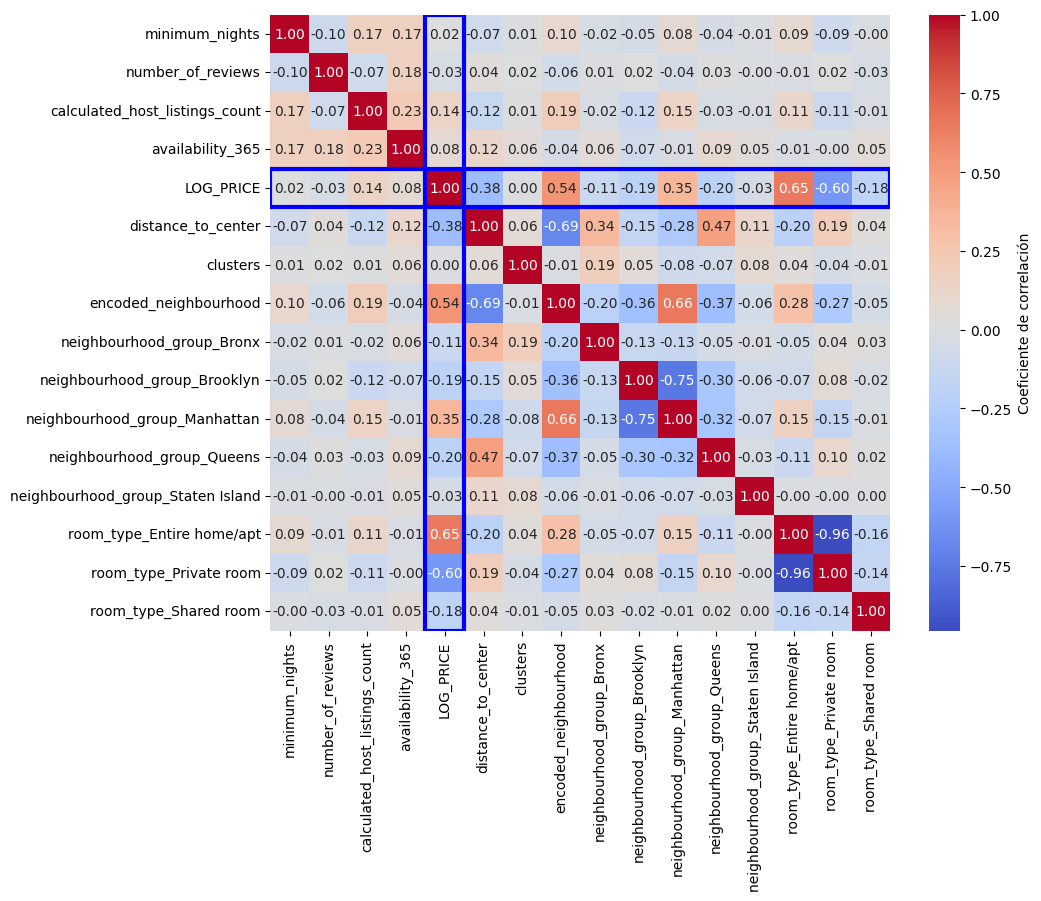

In [38]:
# De nuevo mapa de correlacion // despues del ajuste las correlaciones son mas claras

def corr_highlighted_target(dataframe, target):
    corr = dataframe.corr()
    # Generar el mapa de calor de la matriz de correlación
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Coeficiente de correlación'})

    # Resaltar la columna y fila de la variable objetivo
    # Encontrar el índice de la variable objetivo en las columnas
    target_index = dataframe.columns.tolist().index(target)

    # Cambiar el color de la columna y fila correspondiente a la variable objetivo
    plt.gca().add_patch(plt.Rectangle((target_index, 0), 1, len(corr), fill=False, edgecolor='blue', lw=3))
    plt.gca().add_patch(plt.Rectangle((0, target_index), len(corr), 1, fill=False, edgecolor='blue', lw=3))

    plt.show()
corr_highlighted_target(df_for_model, 'LOG_PRICE')


### Escalado

In [39]:
# Separamos la variable dependiente e independiente
X = df_for_model.drop(['LOG_PRICE'], axis=1)
y = df_for_model['LOG_PRICE']

# Dividimos los datos para el modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
# Dividimos los datos en cuantitativos y binarios para el escalado y posterior concatenacion

# Definimos columnas no binarias
num_cols = [ 'minimum_nights',	'number_of_reviews','calculated_host_listings_count', 'availability_365','distance_to_center',	'encoded_neighbourhood']
# Creamos dos conjuntos de datos independientes binarios/cuantitativos

X_train_bin = X_train.drop(num_cols, axis=1)
X_test_bin = X_test.drop(num_cols, axis=1)

X_train_num = X_train[num_cols]
X_test_num = X_test[num_cols]

In [41]:
# Creamos una instancia al metodo de escalado
scaler = MinMaxScaler().fit(X_train_num)

# Escalamos solo los valores cuantitativos
X_train_sc = scaler.transform(X_train_num)
X_test_sc = scaler.transform(X_test_num)

In [42]:
# convertimos los resultados del escalado a dataframe
X_train_sc_df = pd.DataFrame(X_train_sc, columns=X_train_num.columns, index=X_train_num.index)
X_test_sc_df = pd.DataFrame(X_test_sc, columns=X_test_num.columns, index=X_test_num.index)



In [43]:
# Unimos los datos cuantitativos con los binarios
X_train_final = pd.concat([X_train_sc_df, X_train_bin], axis=1)
X_test_final = pd.concat([X_test_sc_df, X_test_bin], axis=1)



In [44]:
# dataframe resultado
X_test_final

,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,distance_to_center,encoded_neighbourhood,clusters,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
35961,0.00,0.05,0.00,0.77,0.07,0.60,4,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00
13883,0.00,0.08,0.00,0.01,0.09,0.67,12,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00
10421,0.00,0.44,0.00,0.00,0.44,0.28,5,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00
12507,0.02,0.00,0.00,0.14,0.21,0.52,0,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00
43705,0.00,0.02,0.00,0.41,0.34,0.36,1,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4077,0.00,0.00,0.00,0.00,0.14,0.76,9,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00
23715,0.00,0.00,0.00,0.00,0.20,0.37,12,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00
43269,0.00,0.01,0.00,0.70,0.18,0.52,0,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00
42769,0.00,0.00,0.02,0.99,0.05,0.73,4,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00


### Busqueda de modelo

In [45]:
# Buscamos el modelo que mejor desempeño tenga
from lazypredict.Supervised import LazyRegressor
reg = LazyRegressor()
# aplicamos 
models, predictions = reg.fit(X_train_final, X_test_final, y_train, y_test)

  0%|          | 0/42 [00:00<?, ?it/s]

 98%|█████████▊| 41/42 [03:35<00:08,  8.41s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1068
[LightGBM] [Info] Number of data points in the train set: 36994, number of used features: 15
[LightGBM] [Info] Start training from score 4.696070


100%|██████████| 42/42 [03:35<00:00,  5.13s/it]


In [46]:
# Imprimimos los resultados 
print(models)


                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
LGBMRegressor                                0.64       0.64  0.37        0.34
HistGradientBoostingRegressor                0.64       0.64  0.37        0.69
XGBRegressor                                 0.64       0.64  0.37        0.37
GradientBoostingRegressor                    0.63       0.63  0.38        4.65
RandomForestRegressor                        0.62       0.62  0.38       14.21
NuSVR                                        0.62       0.62  0.39       73.36
SVR                                          0.62       0.62  0.39       54.62
MLPRegressor                                 0.61       0.61  0.39        8.28
BaggingRegressor                             0.59       0.59  0.40        1.74
ExtraTreesRegressor                          0.59       0.59  0.40        7.82
LarsCV                                       0.58   

### Busqueda de hiperparametros

In [47]:
# Buscaremos un mejor ajuste del modelo LGBMRegressor ( El segundo de la lista, mismo desempeño pero algo mas rapido en ejecución)
model = lgb.LGBMRegressor(force_col_wise=True)
# Establecemos el rango de hiperparametros sobre los que iterará RandomizedSearchCV
param_dict = {'boosting_type': ['gbdt','dart','rf'],
              'num_leaves': np.arange(10, 250, 10),
              'max_depth':np.arange(10, 250, 10),
              'learning_rate':np.logspace(-3,0,5),
              'bagging_fraction': np.linspace(0.1, 0.9, 10),
              'bagging_freq': np.arange(1, 10, 1),
              'feature_fraction': np.linspace(0.1, 0.9, 10),
              'n_estimators': np.arange(0, 250, 10)}
# Creamos una instancia de RandomizedSearchCV
random_search = RandomizedSearchCV(model, param_distributions=param_dict, n_iter=50, cv=5, random_state=42, n_jobs=-1, scoring='neg_root_mean_squared_error', verbose=2)
# Llamamos al metodo fit de la instancia creada que efectuara una busqueda aleatoria de la mejor combinacion de hiperparametros
random_search.fit(X_train_final, y_train)                  

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Warning] feature_fraction is set=0.8111111111111111, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8111111111111111
[LightGBM] [Warning] bagging_fraction is set=0.2777777777777778, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2777777777777778
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] feature_fraction is set=0.8111111111111111, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8111111111111111
[LightGBM] [Warning] bagging_fraction is set=0.2777777777777778, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2777777777777778
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is

[LightGBM] [Warning] feature_fraction is set=0.8111111111111111, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8111111111111111
[LightGBM] [Warning] bagging_fraction is set=0.6333333333333333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6333333333333333
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[CV] END bagging_fraction=0.6333333333333333, bagging_freq=8, boosting_type=dart, feature_fraction=0.8111111111111111, learning_rate=1.0, max_depth=120, n_estimators=110, num_leaves=30; total time=   1.9s
[LightGBM] [Warning] feature_fraction is set=0.8111111111111111, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8111111111111111
[LightGBM] [Warning] bagging_fraction is set=0.6333333333333333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6333333333333333
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current

RandomizedSearchCV(cv=5, estimator=LGBMRegressor(force_col_wise=True),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bagging_fraction': array([0.1       , 0.18888889, 0.27777778, 0.36666667, 0.45555556,
       0.54444444, 0.63333333, 0.72222222, 0.81111111, 0.9       ]),
                                        'bagging_freq': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'boosting_type': ['gbdt', 'dart', 'rf'],
                                        'feature_fraction': array([0.1       , 0.18888...
                                        'max_depth': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240]),
                                        'n_estimators': array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240]),
                                        'num_leaves': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240])},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [49]:
# Mostramos los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(random_search.best_params_)

# Mostramos el rendimiento del mejor modelo
print("Mejor puntuación (RMSE) en el conjunto de prueba:")
print(-1*random_search.best_score_)

Mejores hiperparámetros encontrados:
{'num_leaves': 170, 'n_estimators': 240, 'max_depth': 240, 'learning_rate': 0.03162277660168379, 'feature_fraction': 0.5444444444444445, 'boosting_type': 'gbdt', 'bagging_freq': 5, 'bagging_fraction': 0.6333333333333333}
Mejor puntuación (RMSE) en el conjunto de prueba:
0.3746522798336562


In [50]:
# intentamos ajustar aun mas los hiperparametros con el metodo bayesiano
# Creamos una instancia LGBMRegressor
model = lgb.LGBMRegressor()
# Establecemos el rango de hiperparametros
param_dict = {'boosting_type': ['gbdt'],
              'num_leaves': np.arange(150, 250, 5),
              'max_depth':np.arange(200, 300, 5),
              'learning_rate':[0.02, 0.025, 0.04,0.045,0.05],
              'n_estimators': np.arange(200, 300, 5)}

# Inicializa el objeto BayesSearchCV
opt = BayesSearchCV(
    model,
    param_dict,
    n_iter=50,  # Número de iteraciones de la búsqueda
    cv=5,       # Número de divisiones en validación cruzada
    n_jobs=-1,
    random_state=42,
    scoring='neg_root_mean_squared_error',  # Métrica a optimizar
    verbose=2
)

# Realiza la búsqueda bayesiana
opt.fit(X_train_final, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1075
[LightGBM] [Info] Number of data points in the train set: 29595, number of used features: 15
[LightGBM] [Info] Start training from score 4.697235
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1079
[LightGBM] [Info] Number of data points in the train set: 29595, number of used features: 15
[LightGBM] [Info] Start training from score 4.695898
[CV] END boosting_type=gbdt, learning_rate=0.045, max_depth=290, n_estimators=230, num_leaves=215

BayesSearchCV(cv=5, estimator=LGBMRegressor(), n_jobs=-1, random_state=42,
              scoring='neg_root_mean_squared_error',
              search_spaces={'boosting_type': ['gbdt'],
                             'learning_rate': [0.02, 0.025, 0.04, 0.045, 0.05],
                             'max_depth': array([200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260,
       265, 270, 275, 280, 285, 290, 295]),
                             'n_estimators': array([200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260,
       265, 270, 275, 280, 285, 290, 295]),
                             'num_leaves': array([150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210,
       215, 220, 225, 230, 235, 240, 245])},
              verbose=2)

In [56]:
# Imprimimos los mejores hiperparámetros
print("Mejores hiperparámetros encontrados:")
print(opt.best_params_)

# Mostramos el rendimiento del mejor modelo
print("Mejor puntuación (RMSE) en el conjunto de prueba:")
print(-1*opt.best_score_)

Mejores hiperparámetros encontrados:
OrderedDict([('boosting_type', 'gbdt'), ('learning_rate', 0.025), ('max_depth', 250), ('n_estimators', 270), ('num_leaves', 160)])
Mejor puntuación (RMSE) en el conjunto de prueba:
0.3751073530601853


### Modelos optimizados

In [57]:
# Obtenemos los modelos con los mejores hiperparametros 
model = opt.best_estimator_
model2 = random_search.best_estimator_

### Modelo sin optimizar
----------------------------------------------------------------------------------------------------------------

In [66]:
model3 = lgb.LGBMRegressor()
model3.fit(X_train_final, y_train)

y_pred_train = np.exp(model3.predict(X_train_final))
y_pred_test = np.exp(model3.predict(X_test_final))
# Reconvertimos a la escala original los valores objetivo reales
y_train_euros = np.exp(y_train)
y_test_euros = np.exp(y_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1092
[LightGBM] [Info] Number of data points in the train set: 36994, number of used features: 15
[LightGBM] [Info] Start training from score 4.696070


In [67]:
# Imprimimos los valores de r**2
print(r2_score(y_train_euros,y_pred_train))
print(r2_score(y_test_euros,y_pred_test))

0.5205667096815335
0.5088390964726011


In [68]:
# imprimimos los valores del error medio absoluto
print(mean_absolute_percentage_error(y_train_euros,y_pred_train)*100)
print(mean_absolute_percentage_error(y_test_euros,y_pred_test)*100)

28.090067979957084
29.454543886575884


----------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------

### Modelo optimizado con random search
----------------------------------------------------------------------------------------------------------------

In [58]:
model2.fit(X_train_final, y_train)
# Usamos el modelo final para efectuar las predicciones, reconvirtiendo el resultado a dolares con np.exp
y_pred_train = np.exp(model2.predict(X_train_final))
y_pred_test = np.exp(model2.predict(X_test_final))
# Reconvertimos a la escala original los valores objetivo reales
y_train_euros = np.exp(y_train)
y_test_euros = np.exp(y_test)

[LightGBM] [Warning] feature_fraction is set=0.5444444444444445, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5444444444444445
[LightGBM] [Warning] bagging_fraction is set=0.6333333333333333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6333333333333333
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.5444444444444445, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5444444444444445
[LightGBM] [Warning] bagging_fraction is set=0.6333333333333333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6333333333333333
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Total Bins 1092
[LightGBM] [Info] Number of data points in the train set: 36994, num

In [59]:
# Imprimimos los valores de r**2
print(r2_score(y_train_euros,y_pred_train))
print(r2_score(y_test_euros,y_pred_test))

0.5846073001028904
0.5143139236629284


In [60]:
# imprimimos los valores del error medio absoluto
print(mean_absolute_percentage_error(y_train_euros,y_pred_train)*100)
print(mean_absolute_percentage_error(y_test_euros,y_pred_test)*100)

25.58381902063895
29.121549994631557


----------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------

##### Modelo optimizado sobre los valores de hipermarametros de random search con busqueda Bayesiana
----------------------------------------------------------------------------------------------------------------

In [61]:
model.fit(X_train_final, y_train)
# Usamos el modelo final para efectuar las predicciones, reconvirtiendo el resultado a dolares con np.exp
y_pred_train = np.exp(model.predict(X_train_final))
y_pred_test = np.exp(model.predict(X_test_final))
# Reconvertimos a la escala original los valores objetivo reales
y_train_euros = np.exp(y_train)
y_test_euros = np.exp(y_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000794 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1092
[LightGBM] [Info] Number of data points in the train set: 36994, number of used features: 15
[LightGBM] [Info] Start training from score 4.696070


In [62]:
# Imprimimos los valores de r**2
print(r2_score(y_train_euros,y_pred_train))
print(r2_score(y_test_euros,y_pred_test))

0.5906133900578994
0.5165749682253773


In [63]:
# imprimimos los valores del error medio absoluto
print(mean_absolute_percentage_error(y_train_euros,y_pred_train)*100)
print(mean_absolute_percentage_error(y_test_euros,y_pred_test)*100)

25.46436598674215
29.200249096962043


### No se aprecian apenas diferencias entre modelos optimizados y no optimizados :(